# Every model was created using the same development-test split.

In [4]:
# Load all helper function
%run -i 'source.py'

dataset = pd.read_feather("../processing/train_with_feature.feather")
X = dataset[numc_features + ohe_features + te_features]
y = dataset['is_attributed']

In [5]:
X, _, y, _ = train_test_split(X, y, random_state=4995, train_size=.0081, stratify=y)

In [6]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=4995, test_size=0.2, stratify=y)

# Function to Evaluate Models saved as .sav Files (Must support predict_proba)

In [140]:
def ModelEvaluation(ModelFileName,Title_Of_Model):
    """
    ModelFileName is a string containing the name of the .sav file in which you saved your trained model.
    Title_Of_Model is just something simple such as Random Forest/XGBoost. When plotting PR curve, it will be titled "Precision-Recall Curve of Title_Of_Model Model"
    """
    sns.set(rc = {'figure.figsize':(10,7)})
    model = pickle.load(open(ModelFileName,'rb'))
    
    probabilities = model.predict_proba(X_test)[:,1]   #X_test is a global variable specific to this notebook
    precision, recall, thresholds = precision_recall_curve(y_test, probabilities) #y_test is another global variable specific to this notebook
    
    graph = sns.lineplot(x=recall, y = precision)
    graph.axhline(.6,linewidth=1, color='k')  # We decided to compare Recall at .6 precision level
    graph.set_xlabel("Recall (Positive Label: 1)")
    graph.set_ylabel("Precision (Positive Label: 1)")
    
    sns.regplot(x=np.array([np.mean(recall[abs(precision - .6)<.001])]), y=np.array([.6]), 
            scatter=True, fit_reg=False, marker='o',scatter_kws={"s": 50})
    graph.set_title("Precision-Recall Curve for " + Title_Of_Model + " Model")
    recall = np.mean(recall[abs(precision - .6)<.001])

    print(f"At .6 precision, we achieve a recall of approximately {recall:0.2f}")
    print(f'This an F-1 Score of {(2*recall*.6)/(recall + .6):0.2f}') 

# Evaluating Logistic Regresssion Model

At .6 precision, we achieve a recall of approximately nan
This an F-1 Score of nan


/root/miniconda3/envs/myconda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


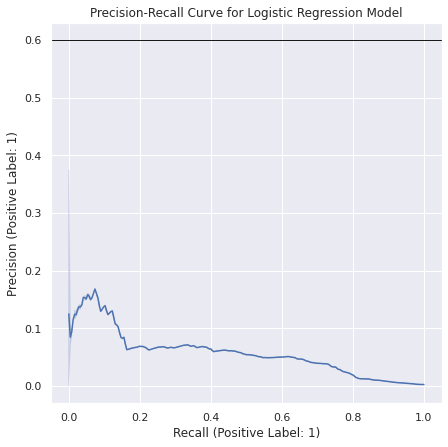

In [144]:
ModelEvaluation("../processing/LogisticRegression.sav", "Logistic Regression")

**Logistic Regression returns an error since the model can never achieve a precision of 0.6.**

# Evaluating Linear SVM Model

At .6 precision, we achieve a recall of approximately 0.82
This an F-1 Score of 0.69


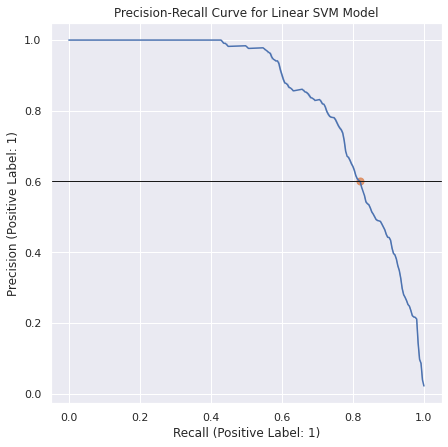

In [145]:
ModelEvaluation("../processing/LinearSVM.sav","Linear SVM")

# Evaluating Random Forest Model

At .6 precision, we achieve a recall of approximately 0.95
This an F-1 Score of 0.74


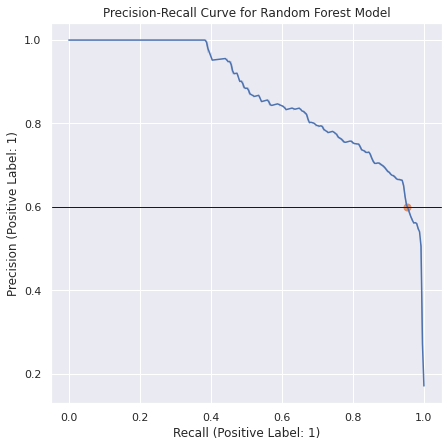

In [146]:
ModelEvaluation("../processing/RandomForest.sav","Random Forest")

# Evaluating XGBoost Model

At .6 precision, we achieve a recall of approximately 1.00
This an F-1 Score of 0.75


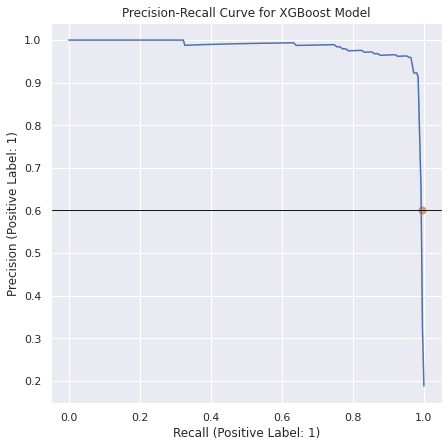

In [148]:
ModelEvaluation("../processing/XGB_tunned.sav","XGBoost")

# Evaluating LightGBM Model

At .6 precision, we achieve a recall of approximately 0.94
This an F-1 Score of 0.73


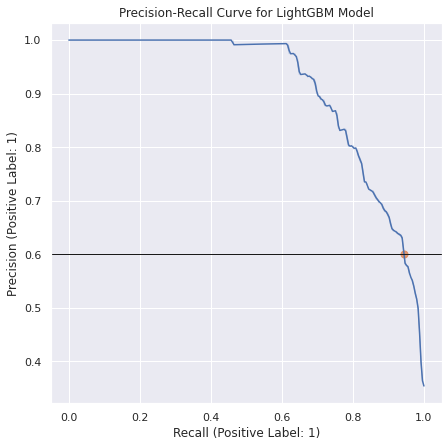

In [149]:
ModelEvaluation("../processing/lgbm.sav","LightGBM")

In [333]:
def CompilePRCurves(ModelFileNames: list, ModelTitles: list, MainThresh = 0.6, ExtraThresh = [0.4, 0.8, 0.9], ExtraPrec = False, save = False):
    """
    ModelFileNames is a list of strings containing the name of the .sav file in which you saved your trained model.
    ModelTitles is list of model names plotted
    MainThresh is the main precision threshold used for judging recall
    ExtraThresh are addition precision thresholds at which recall will be calculated. Default to calc is False (ExtraPrec)
    save indicates if output PR plot is saved as png
    """
    
    sns.set(rc = {'figure.figsize':(10,7)})
    fig, ax = plt.subplots()
    
    #init metrics to capture
    AP = dict()
    f1 = dict()
    if ExtraPrec:
        keys = [MainThresh] + ExtraThresh
        keys.sort()
        all_recalls = {k: dict() for k in keys}
    else:
        all_recalls = {MainThresh: dict()}
    
    #Generate main PR Curves
    for model_name, model_title in zip(ModelFileNames, ModelTitles):
        model = pickle.load(open(model_name,'rb'))
        probabilities = model.predict_proba(X_test)[:,1]   #X_test is a global variable specific to this notebook
        y_preds = model.predict(X_test)
        precision, recall, thresholds = precision_recall_curve(y_test, probabilities) #y_test is another global variable specific to this notebook
        ax.plot(recall, precision, linewidth=2)
        
        for prec_thresh in all_recalls.keys():
            rec_val = np.mean(recall[abs(precision - prec_thresh)<.001])
            if not np.isnan(rec_val):
                all_recalls[prec_thresh][model_title] = rec_val
            else:
                rec_val = np.mean(recall[abs(precision - prec_thresh)<.002]) #Get Recall when precision is at threshold within error of 0.002
                all_recalls[prec_thresh][model_title] = rec_val
                
        AP[model_title] = average_precision_score(y_test, probabilities)   #record AP
        f1[model_title] = f1_score(y_test, y_preds)   #record F1 score
   
    #Plot the recall point when precision is at the Main Precision Threshold (default 0.6)
    prec_60_y = [MainThresh] * len(all_recalls[MainThresh].keys())
    ax.plot(list(all_recalls[MainThresh].values()), prec_60_y, 'ro')    
    ax.axhline(MainThresh,linewidth=1, color='k')
    #Add other precision thresholds
    for thresh in ExtraThresh:
        ax.axhline(thresh, linewidth = 0.5, ls = '--', color = 'k')
    
    ax.set_xlabel("Recall (Positive Label: 1)")
    ax.set_ylabel("Precision (Positive Label : 1)")
    ax.set_title("Precision-Recall Curve for all Models", {'fontsize':14})
    ax.legend(ModelTitles, loc=2 , bbox_to_anchor=(0.05, 0.5))
    
    plt.show()
    
    if save:
        fig.savefig('../output/PRCurves.png')
    return AP, f1, all_recalls

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


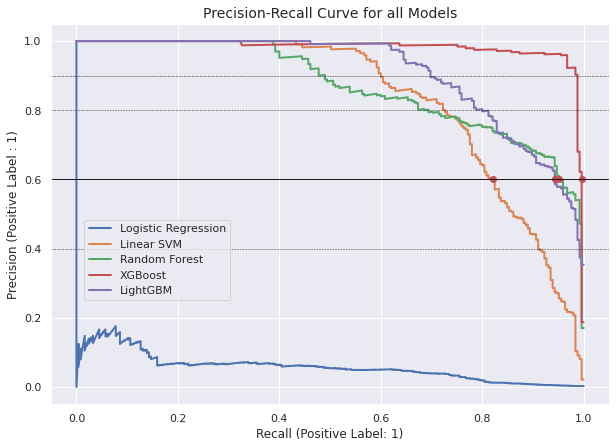

In [334]:
file_names = ["../processing/" + model_name for model_name in ["LogisticRegression.sav", "LinearSVM.sav", "RandomForest.sav", "XGB_tunned.sav", "lgbm.sav"]]
model_names= ["Logistic Regression", "Linear SVM", "Random Forest","XGBoost", "LightGBM"]
f1, AP, all_recalls = CompilePRCurves(file_names, model_names, ExtraPrec = True, save = True)

In [335]:
df1 = pd.DataFrame({'AP':AP, "f1": f1})
df1.applymap(lambda x: round(x,3))

,AP,f1
Logistic Regression,0.024,0.058
Linear SVM,0.748,0.837
Random Forest,0.778,0.871
XGBoost,0.953,0.982
LightGBM,0.799,0.910


In [336]:
df2 = pd.DataFrame(all_recalls)
df2.applymap(lambda x: round(x, 3), na_action='ignore')

,0.4,0.6,0.8,0.9
Logistic Regression,NaN,NaN,NaN,NaN
Linear SVM,0.910,0.820,0.722,0.600
Random Forest,0.996,0.951,0.683,0.480
XGBoost,0.996,0.996,0.988,0.988
LightGBM,0.992,0.943,0.800,0.698
